In [1]:
!pip install -q --upgrade pip
!pip install -q "transformers>=4.30.0" "datasets" "accelerate>=0.21.0" "peft>=0.4.0" "bitsandbytes>=0.39.0" "sentencepiece" "safetensors" "torchinfo"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 24.1 MB/s eta 0:00:0000:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
pylibcudf-cu12 25.2.2 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.
cudf-cu12 25.2.2 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.
bigframes 2.12.0 requires google-cloud-bigquery[bqstorage,pandas]>=3.31.0, but you have google-cloud-bigquery 3.25.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.1.0 which is incompatible.
libcugraph-cu12 25.6.0 requires libraft-cu12==25.6.*, but you have libraft-cu12 25.2.0 which is incompatible.
gradio 5.38.1 requires pyda

In [2]:
!pip install transformers accelerate torchinfo

In [3]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model_path = "/kaggle/input/llama-3.2-3b-instruct/pytorch/default/1"

model = AutoModelForCausalLM.from_pretrained(
    model_path,
    device_map="auto",      # loads layers automatically on available GPUs/CPU
    torch_dtype="auto"
)
tokenizer = AutoTokenizer.from_pretrained(model_path)

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

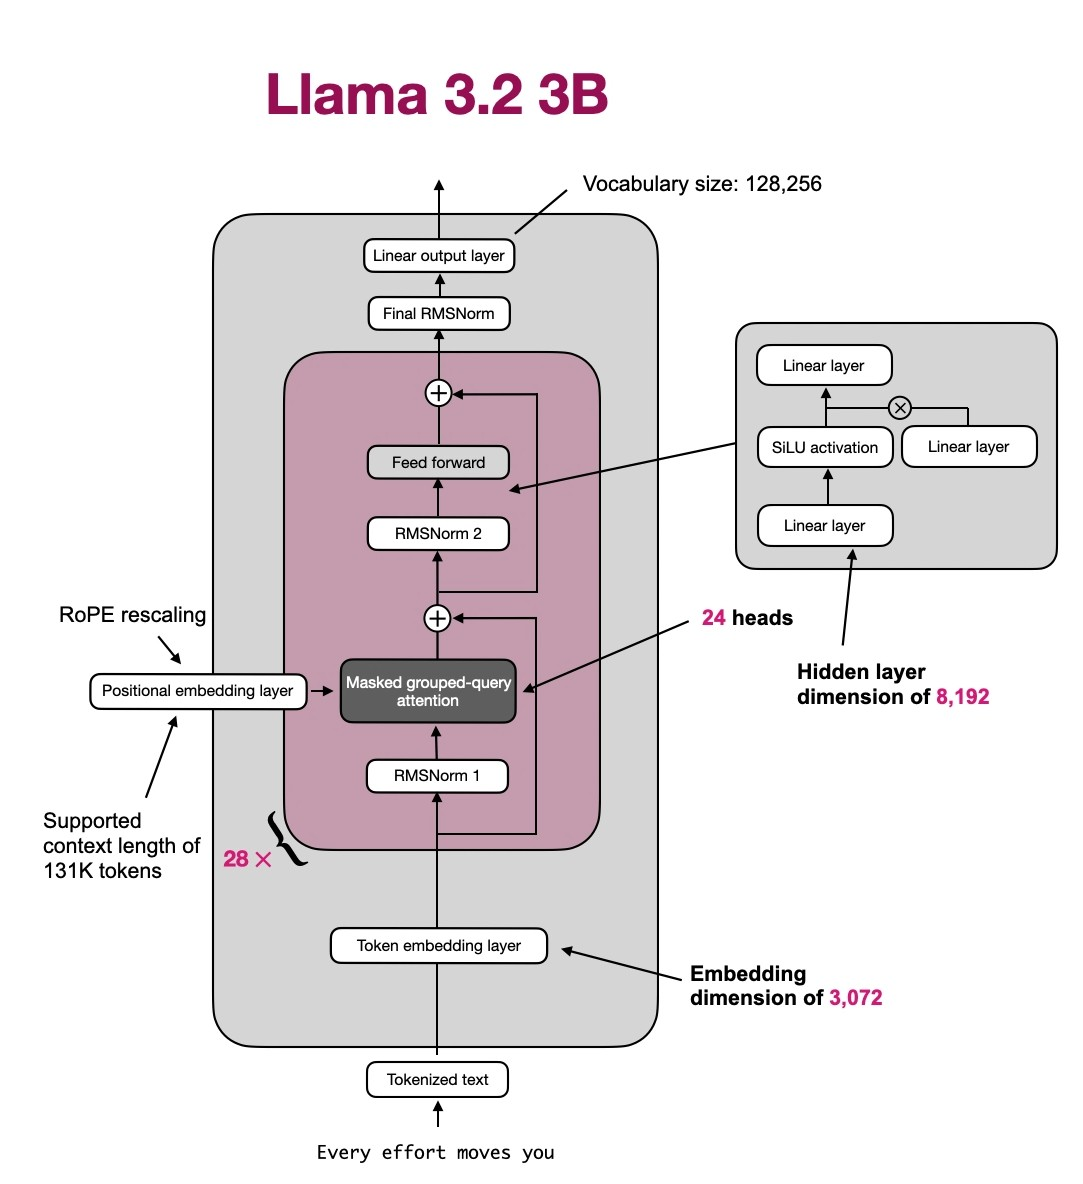

In [4]:
from IPython.display import Image, display

image_path = "/kaggle/input/llama-architecture/llama32_architecture.jpg"
display(Image(filename=image_path))

In [5]:
import torch
from prettytable import PrettyTable

# === Load Model ===
MODEL_NAME = "/kaggle/input/llama-3.2-3b-instruct/pytorch/default/1"
model = AutoModelForCausalLM.from_pretrained(MODEL_NAME, device_map="auto", torch_dtype="auto")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# === Get one decoder layer ===
layer = model.model.layers[0]

# === Create PrettyTable ===
table = PrettyTable()
table.field_names = ["Layer Name", "Type", "Input Dim", "Output Dim", "Weight Shape", "Parameters"]

# Helper function for adding Linear layers
def add_linear(name, linear_module):
    in_dim = linear_module.in_features
    out_dim = linear_module.out_features
    shape = tuple(linear_module.weight.shape)
    params = linear_module.weight.numel()
    table.add_row([name, "Linear", in_dim, out_dim, shape, f"{params:,}"])
    return params

# === SELF-ATTENTION ===
attn = layer.self_attn
sa_total = 0
sa_total += add_linear("q_proj", attn.q_proj)
sa_total += add_linear("k_proj", attn.k_proj)
sa_total += add_linear("v_proj", attn.v_proj)
sa_total += add_linear("o_proj", attn.o_proj)
table.add_row(["→ self_attn (total)", "LlamaAttention", "-", "-", "-", f"{sa_total:,}"])

# === MLP ===
mlp = layer.mlp
mlp_total = 0
mlp_total += add_linear("gate_proj", mlp.gate_proj)
mlp_total += add_linear("up_proj", mlp.up_proj)
mlp_total += add_linear("down_proj", mlp.down_proj)
table.add_row(["→ mlp (total)", "LlamaMLP", "-", "-", "-", f"{mlp_total:,}"])

# === LayerNorms ===
for name, norm in [("input_layernorm", layer.input_layernorm),
                   ("post_attention_layernorm", layer.post_attention_layernorm)]:
    params = sum(p.numel() for p in norm.parameters())
    table.add_row([name, "LlamaRMSNorm", "-", "-", "-", f"{params:,}"])

# === Total for 1 Decoder Layer ===
decoder_total = sa_total + mlp_total
for norm in [layer.input_layernorm, layer.post_attention_layernorm]:
    decoder_total += sum(p.numel() for p in norm.parameters())
table.add_row(["TOTAL (1 Decoder Layer)", "LlamaDecoderLayer", "-", "-", "-", f"{decoder_total:,}"])

num_layers = len(model.model.layers)
table.add_row([f"TOTAL ({num_layers} Decoder Layer)", "LlamaDecoderLayer", "-", "-", "-", f"{decoder_total * num_layers:,}"]) # Parameter for all decoder layers

# # lm head
# lm_head = model.get_output_embeddings()
# params = lm_head.weight.numel()
# table.add_row(["lm_head", "Linear", in_dim, out_dim, shape, f"{params:,}"])

# # Total parameters
# table.add_row(["Total Parameters", "Linear", in_dim, out_dim, shape, f"{decoder_total * num_layers + params:,}"])

# === PRINT TABLE ===
print(table)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

+--------------------------+-------------------+-----------+------------+--------------+---------------+
|        Layer Name        |        Type       | Input Dim | Output Dim | Weight Shape |   Parameters  |
+--------------------------+-------------------+-----------+------------+--------------+---------------+
|          q_proj          |       Linear      |    3072   |    3072    | (3072, 3072) |   9,437,184   |
|          k_proj          |       Linear      |    3072   |    1024    | (1024, 3072) |   3,145,728   |
|          v_proj          |       Linear      |    3072   |    1024    | (1024, 3072) |   3,145,728   |
|          o_proj          |       Linear      |    3072   |    3072    | (3072, 3072) |   9,437,184   |
|   → self_attn (total)    |   LlamaAttention  |     -     |     -      |      -       |   25,165,824  |
|        gate_proj         |       Linear      |    3072   |    8192    | (8192, 3072) |   25,165,824  |
|         up_proj          |       Linear      |    307

In [6]:
print(f"Number of decoder layers: {num_layers}")

Number of decoder layers: 28


In [7]:
import os
import sys
import json
import glob
from pathlib import Path
import torch

print("Python:", sys.version.splitlines()[0])
print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("CUDA device:", torch.cuda.get_device_name(0))
else:
    print("Warning: CUDA not available.")

import transformers, datasets, peft, bitsandbytes, accelerate
print("transformers:", transformers.__version__)
print("datasets:", datasets.__version__)
print("peft:", peft.__version__)
import bitsandbytes as bnb
print("bitsandbytes:", bnb.__version__)

Python: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
Torch: 2.6.0+cu124
CUDA available: True
CUDA device: Tesla T4
transformers: 4.53.3
datasets: 4.1.1
peft: 0.16.0
bitsandbytes: 0.48.1


In [8]:
DATA_PATH = "/kaggle/input/finance-finetuning-dataset-combined"
BASE_MODEL_PATH = "/kaggle/input/llama-3.2-3b-instruct/pytorch/default/1"
OUTPUT_DIR = "/kaggle/working/qlora_lora_finance"  # where adapters/checkpoints will be saved

# Training hyperparameters
MICRO_BATCH_SIZE = 2       
GRAD_ACCUM_STEPS = 16          
EPOCHS = 5
LEARNING_RATE = 4e-4
CUTOFF_LEN = 1024              # token sequence length (common for LLaMA-like models)
LORA_R = 4
LORA_ALPHA = 32
LORA_DROPOUT = 0.05
SEED = 42

os.makedirs(OUTPUT_DIR, exist_ok=True)
print("DATA_PATH:", DATA_PATH)
print("BASE_MODEL_PATH:", BASE_MODEL_PATH)
print("OUTPUT_DIR:", OUTPUT_DIR)


DATA_PATH: /kaggle/input/finance-finetuning-dataset-combined
BASE_MODEL_PATH: /kaggle/input/llama-3.2-3b-instruct/pytorch/default/1
OUTPUT_DIR: /kaggle/working/qlora_lora_finance


In [9]:
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

device = "cuda" if torch.cuda.is_available() else "cpu"

print("Loading tokenizer from:", BASE_MODEL_PATH)
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_PATH, use_fast=False, trust_remote_code=True)

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# BitsAndBytes 4-bit config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.float16,
)

print("Loading base model (4-bit)")
model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL_PATH,
    device_map={"": torch.cuda.current_device()},
    quantization_config=bnb_config,
    trust_remote_code=True,
)

# Freeze base model parameters
for param in model.parameters():
    param.requires_grad = False

print("Model loaded. Parameetrs are freezed.")

Loading tokenizer from: /kaggle/input/llama-3.2-3b-instruct/pytorch/default/1
Loading base model (4-bit)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Model loaded. Parameetrs are freezed.


In [10]:
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training

# Prepare the model for k-bit training (adjusts some layers / casts)
model = prepare_model_for_kbit_training(model)

# PEFT will ignore them. Typical attention projection names for LLaMA-like models:
target_modules = [
    "q_proj", "v_proj", "k_proj", "o_proj",
    "gate_proj", "down_proj", "up_proj",
    "wi", "wo", "wq", "wv", "wk", "wo"
]

lora_config = LoraConfig(
    r=LORA_R,
    lora_alpha=LORA_ALPHA,
    target_modules=target_modules,
    lora_dropout=LORA_DROPOUT,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()  # show how many params will be trained


trainable params: 6,078,464 || all params: 3,218,828,288 || trainable%: 0.1888


In [11]:
# for name, param in model.named_parameters():
#     if "lora" in name.lower():
#         print(f"{name:<100}  shape={tuple(param.shape)}")

In [12]:
from datasets import load_dataset, Dataset, DatasetDict

def find_data_files(path):
    p = Path(path)
    if p.is_file():
        return [str(p)]
    # If it's a dir, look for .jsonl/.json/.csv
    files = []
    for ext in ("*.jsonl","*.json","*.csv"):
        files.extend(sorted([str(x) for x in p.glob(ext)]))
    return files

data_files = find_data_files(DATA_PATH)
if len(data_files) == 0:
    raise FileNotFoundError(f"No dataset files found at {DATA_PATH}. Expect .jsonl/.json/.csv or a file path.")
print("Found data files:", data_files[:10])

# The dataset has fields: instruction, input, output (answer)
sample_file = data_files[0]
if sample_file.endswith(".csv"):
    raw = load_dataset("csv", data_files=data_files)
else:
    # try json (datasets handles jsonl too)
    raw = load_dataset("json", data_files=data_files)

# If the dataset has splits, unify to train split
if "train" in raw:
    ds = raw["train"]
else:
    # raw could be a single split
    split_name = list(raw.keys())[0]
    ds = raw[split_name]

print("Dataset size:", len(ds))
print("Some columns:", ds.column_names)
print("Sample record:", ds[0])


Found data files: ['/kaggle/input/finance-finetuning-dataset-combined/Finance_finetuning_dataset_combined.jsonl']


Generating train split: 0 examples [00:00, ? examples/s]

Dataset size: 20083
Some columns: ['instruction', 'input', 'output', 'question', 'answer']
Sample record: {'instruction': '<title>Minority Depository Institution (MDI: Meaning, Benefits, History</title>\n"Semiannual Report to the Congress: April 1, 2019 - September 30, 2019," Page 10.\nFederal Deposit Insurance Corporation. "2019 Minority Depository Institutions: Structure, Performance, and Social Impact," Page 55.\nFederal Deposit Insurance Corporation. "Preservation and Promotion of Minority Depository Institutions."\nFederal Reserve System. "Preserving Minority Depository Institutions - May 2020."\nFederal Register. "Minority Depository Institution Preservation Program."', 'input': 'market+news', 'output': 'The given text passages discuss Minority Depository Institutions.', 'question': None, 'answer': None}


In [13]:
import math
from transformers import PreTrainedTokenizerBase

PROMPT_TEMPLATE = (
    "### Instruction:\n{instruction}\n\n"
    "### Input:\n{input}\n\n"
    "### Response:\n"
)

def make_prompt(example):
    instruction = example.get("instruction") or example.get("Instruction") or example.get("prompt") or ""
    inp = example.get("input") or example.get("Input") or ""
    # If dataset uses 'output' or 'answer' keys:
    output = example.get("output") or example.get("Output") or example.get("answer") or example.get("Answer") or example.get("response") or ""
    prompt = PROMPT_TEMPLATE.format(instruction=instruction.strip(), input=inp.strip())
    full = prompt + output.strip()
    return prompt, full, output

def tokenize_function(example, tokenizer: PreTrainedTokenizerBase):
    prompt, full, output = make_prompt(example)
    # tokenize prompt and full separately to find token lengths
    tokenized_full = tokenizer(full, truncation=True, max_length=CUTOFF_LEN, padding=False)
    tokenized_prompt = tokenizer(prompt, truncation=True, max_length=CUTOFF_LEN, padding=False)
    input_ids = tokenized_full["input_ids"]
    prompt_len = len(tokenized_prompt["input_ids"])
    labels = input_ids.copy()
    # mask prompt tokens - so loss is computed only on the response portion
    labels[:prompt_len] = [-100] * prompt_len
    return {
        "input_ids": input_ids,
        "attention_mask": tokenized_full["attention_mask"],
        "labels": labels,
    }

# Quick tokenization test on a small sample
tok_test = tokenize_function(ds[0], tokenizer)
print("tokenized sample lengths:", {k: len(v) for k,v in tok_test.items()})


tokenized sample lengths: {'input_ids': 141, 'attention_mask': 141, 'labels': 141}


In [14]:
# Shuffle + split
ds = ds.shuffle(seed=SEED)

# small validation split: 2-5% (adjust as dataset size)
val_size = max(1, int(0.02 * len(ds)))
train_ds = ds.select(range(len(ds) - val_size))
val_ds = ds.select(range(len(ds) - val_size, len(ds)))

print("Train size:", len(train_ds), "Val size:", len(val_ds))

# Tokenize with batched mapping
def batched_tokenize(batch):
    results = {"input_ids": [], "attention_mask": [], "labels": []}
    for i in range(len(batch[next(iter(batch.keys()))])):  # iterate rows
        ex = {k: batch[k][i] for k in batch.keys()}
        tok = tokenize_function(ex, tokenizer)
        results["input_ids"].append(tok["input_ids"])
        results["attention_mask"].append(tok["attention_mask"])
        results["labels"].append(tok["labels"])
    return results

# Use batched mapping
train_tok = train_ds.map(batched_tokenize, batched=True, remove_columns=train_ds.column_names)
val_tok = val_ds.map(batched_tokenize, batched=True, remove_columns=val_ds.column_names)

print("Tokenized train columns:", train_tok.column_names)


Train size: 19682 Val size: 401


Map:   0%|          | 0/19682 [00:00<?, ? examples/s]

Map:   0%|          | 0/401 [00:00<?, ? examples/s]

Tokenized train columns: ['input_ids', 'attention_mask', 'labels']


In [15]:
from dataclasses import dataclass
from typing import Dict, List
import torch
from transformers.tokenization_utils_base import PaddingStrategy

@dataclass
class DataCollatorForCausalLM:
    tokenizer: PreTrainedTokenizerBase
    padding: bool = True
    max_length: int = CUTOFF_LEN

    def __call__(self, batch: List[Dict[str, List[int]]]) -> Dict[str, torch.Tensor]:
        input_ids = [torch.tensor(b["input_ids"], dtype=torch.long) for b in batch]
        attention_mask = [torch.tensor(b["attention_mask"], dtype=torch.long) for b in batch]
        labels = [torch.tensor(b["labels"], dtype=torch.long) for b in batch]
        # pad using tokenizer.pad
        pad_token_id = self.tokenizer.pad_token_id
        input_ids = torch.nn.utils.rnn.pad_sequence(input_ids, batch_first=True, padding_value=pad_token_id)
        attention_mask = torch.nn.utils.rnn.pad_sequence(attention_mask, batch_first=True, padding_value=0)
        labels = torch.nn.utils.rnn.pad_sequence(labels, batch_first=True, padding_value=-100)
        return {"input_ids": input_ids, "attention_mask": attention_mask, "labels": labels}

data_collator = DataCollatorForCausalLM(tokenizer=tokenizer)


In [16]:
from transformers import Trainer, TrainingArguments
import inspect
import torch
import shutil
from IPython.display import FileLink
import os

# -------------------------------
# 1️⃣ Prepare TrainingArguments
# -------------------------------
desired_args = dict(
    output_dir=OUTPUT_DIR,
    per_device_train_batch_size=MICRO_BATCH_SIZE,
    per_device_eval_batch_size=MICRO_BATCH_SIZE,
    gradient_accumulation_steps=GRAD_ACCUM_STEPS,
    num_train_epochs=EPOCHS,
    learning_rate=LEARNING_RATE,
    fp16=(True if torch.cuda.is_available() else False),
    logging_steps=50,
    evaluation_strategy="steps",
    eval_steps=500,
    save_strategy="epoch",       # <-- save after each epoch
    save_total_limit=3,          # keep only last 3 epochs
    load_best_model_at_end=False,
    report_to="none",
    ddp_find_unused_parameters=(False if torch.cuda.is_available() else None),
)

# Filter only supported args
sig = inspect.signature(TrainingArguments.__init__)
supported_params = set(sig.parameters.keys())
supported_params.discard('self')
filtered_args = {k: v for k, v in desired_args.items() if (k in supported_params and v is not None)}

training_args = TrainingArguments(**filtered_args)

# -------------------------------
# 2️⃣ Create Trainer
# -------------------------------
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tok,
    eval_dataset=val_tok,
    data_collator=data_collator,
)

print("Trainer created. Starting training...")

# -------------------------------
# 3️⃣ Train and resume if checkpoint exists
# -------------------------------
# Resume automatically if OUTPUT_DIR has checkpoints
def get_last_checkpoint(output_dir):
    checkpoints = [d for d in os.listdir(output_dir) if d.startswith("checkpoint")]
    if checkpoints:
        # Return the latest checkpoint (sorted numerically)
        return os.path.join(output_dir, sorted(checkpoints, key=lambda x: int(x.split('-')[-1]))[-1])
    return None
# last_ckpt = get_last_checkpoint(OUTPUT_DIR)
last_ckpt = "/kaggle/input/checkpoint-1540/other/default/1"

if last_ckpt:
    print(f"Resuming training from checkpoint: {last_ckpt}")
    trainer.train(resume_from_checkpoint=last_ckpt)
else:
    print("No checkpoint found. Starting training from scratch.")
    trainer.train()

# -------------------------------
# 4️⃣ Save final adapters and tokenizer
# -------------------------------
model.save_pretrained(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)
print(f"Final adapters saved to: {OUTPUT_DIR}")

# -------------------------------
# 5️⃣ Zip the output directory for download
# -------------------------------
zip_path = OUTPUT_DIR + ".zip"
shutil.make_archive(OUTPUT_DIR, 'zip', OUTPUT_DIR)
print(f"Zipped output directory: {zip_path}")

# Provide a clickable download link
FileLink(zip_path)


No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Trainer created. Starting training...
Resuming training from checkpoint: /kaggle/input/checkpoint-1232/other/default/1


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss
1250,0.205000
1300,0.209400
1350,0.222500
1400,0.212700
1450,0.218800
1500,0.208400


Final adapters saved to: /kaggle/working/qlora_lora_finance
Zipped output directory: /kaggle/working/qlora_lora_finance.zip


/kaggle/working/qlora_lora_finance.zip

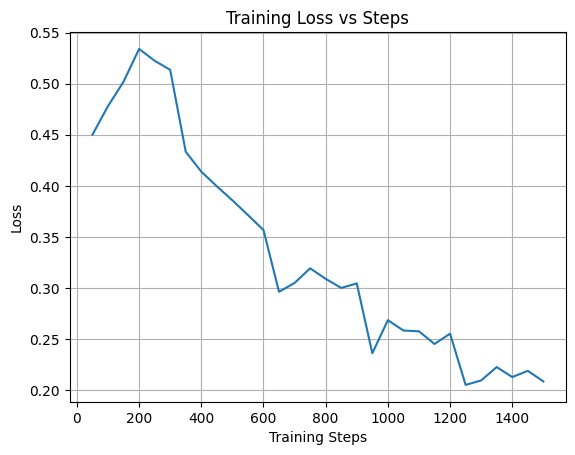

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import os

log_path = os.path.join("/kaggle/working/qlora_lora_finance/checkpoint-1540/trainer_state.json")

with open(log_path, "r") as f:
    logs = json.load(f)

train_loss = [entry["loss"] for entry in logs["log_history"] if "loss" in entry]
steps = [entry["step"] for entry in logs["log_history"] if "loss" in entry]

plt.plot(steps, train_loss)
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Training Loss vs Steps")
plt.grid(True)
plt.xticks(range(0, max(steps)+1, 200))
plt.show()


In [20]:
final_model_dir = os.path.join("/kaggle/working/", "LoRA_Weights")

os.makedirs(final_model_dir, exist_ok=True)
trainer.model.save_pretrained(final_model_dir)
tokenizer.save_pretrained(final_model_dir)

print(f"✅ Fine-tuned model and tokenizer saved to: {final_model_dir}")

✅ Fine-tuned model and tokenizer saved to: /kaggle/working/LoRA_Weights


In [23]:
from peft import AutoPeftModelForCausalLM

merged_model_dir = os.path.join("/kaggle/working/", "fine-tuned_model")
os.makedirs(merged_model_dir, exist_ok=True)

# Load your PEFT model
peft_model = AutoPeftModelForCausalLM.from_pretrained(final_model_dir, device_map="auto")

# Merge adapter + base weights
merged_model = peft_model.merge_and_unload()

# Save the full fine-tuned model
merged_model.save_pretrained(merged_model_dir, safe_serialization=True)
tokenizer.save_pretrained(merged_model_dir)

print(f"✅ Full merged model saved to: {merged_model_dir}")


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

✅ Full merged model saved to: /kaggle/working/fine-tuned_model


In [ ]:
# Zip the final model for download
# -------------------------------
zip_path = final_model_dir + ".zip"
shutil.make_archive(final_model_dir, 'zip', final_model_dir)
print(f"📦 Zipped final model: {zip_path}")

display(FileLink(zip_path))

In [24]:
from peft import PeftModel

print("Loading base model and applying LoRA adapters for inference...")
base = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL_PATH,
    device_map="auto",
    quantization_config=bnb_config,
    trust_remote_code=True,
)

# Load LoRA weights (this will attach them to base model)
from peft import PeftModel
lora_model = PeftModel.from_pretrained(base, OUTPUT_DIR, torch_dtype=torch.float16)
lora_model.eval()

# Example inference
def generate(prompt, max_new_tokens=256, temperature=0.2, top_p=0.95):
    inputs = tokenizer(prompt, return_tensors="pt").to(lora_model.device)
    with torch.no_grad():
        out = lora_model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=True,
            temperature=temperature,
            top_p=top_p,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id,
        )
    return tokenizer.decode(out[0], skip_special_tokens=True)

# Test with a small prompt:
sample_prompt = PROMPT_TEMPLATE.format(instruction="Explain what a dividend yield is", input="")
print(generate(sample_prompt, max_new_tokens=120))


Loading base model and applying LoRA adapters for inference...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

KeyboardInterrupt: 